In [ ]:
#Assignment 4 
#Veronika Wendler
#ID:20375377

#It's difficult to recommend one model as the "most accurate" based solely on these performance metrics,
# as the best model for a particular use case can depend on various factors such as the nature of the data,
# the goals of the analysis, and the resources available.
#That being said, we can look at some of the metrics to gain some insights.
# The Calinski-Harabasz Index measures the ratio of between-cluster variance 
#to within-cluster variance, with higher values indicating better-defined clusters.
# Based on this metric, the K-means clustering with K=3 has the highest score, followed by K=10 and K=30, HOWEVER: Also looking at the
# elbow curve shows us that 
# the clyuster of 10 is optimal. Using different metrices makes it hard to come to a conclusion, but I still wated to apply elbow.
#The DBSCAN algorithm, which automatically determines the number of clusters, has found 2 clusters in the test 
#data using the hyperparameters eps=2.9 and min_samples=8.
#The hierarchical agglomerative clustering has found different cluster sizes in the training and testing sets,
# which could indicate overfitting on the training data. However, the training set Calinski-Harabasz Index is higher 
#than the testing set, which is a good sign. The silhouette index measures the quality of clustering by evaluating how 
#similar objects are within the same cluster and how different they are from objects in other clusters. Based on this metric
#, both the training and testing sets have silhouette index values around 0.11, which is considered to be moderate.

#Using the Calinski index we could say that as score of Centroids=2.354253857665086, Calinski-Harabasz Index=219.71413820305523 for  KMeans of clustersize 3
#is very good, it is rather poor for the DUBSCN model.

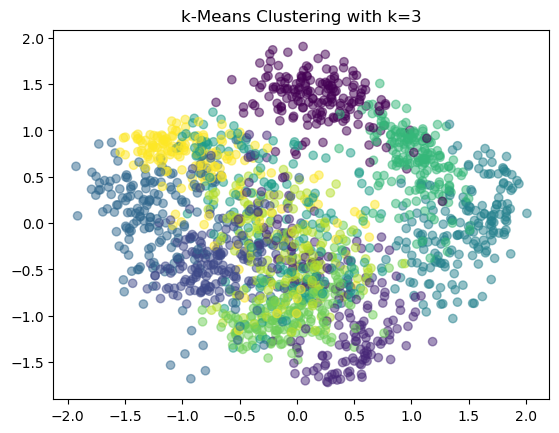

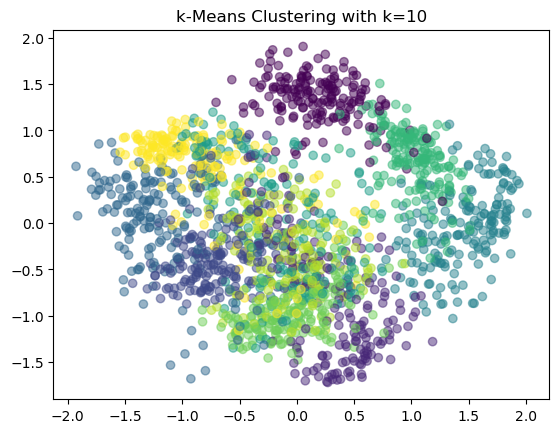

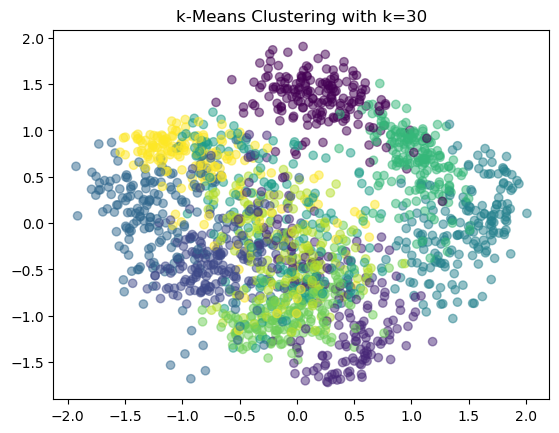

k=3: Mean Distance to Centroids=2.354253857665086, Calinski-Harabasz Index=219.71413820305523
k=10: Mean Distance to Centroids=2.6002143634074195, Calinski-Harabasz Index=165.40276892746456
k=30: Mean Distance to Centroids=2.7201181302098982, Calinski-Harabasz Index=86.24285365535013
The best model has k=3 with a mean distance to centroids of 2.354253857665086 and a Calinski-Harabasz Index of 219.71413820305523


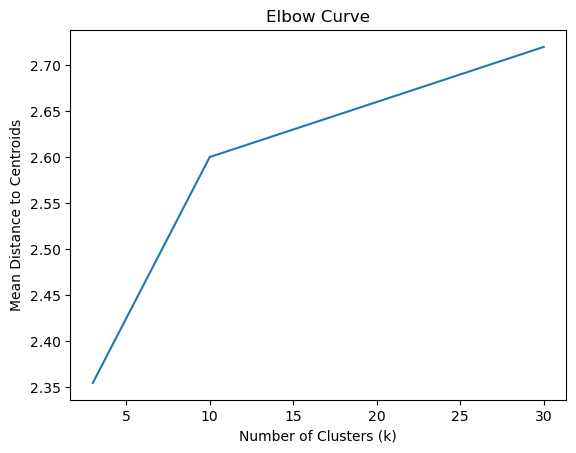

In [8]:
#Code for KMeans 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.metrics import calinski_harabasz_score, pairwise_distances

train_data = pd.read_csv('digitDset_train.csv', header=None)
test_data = pd.read_csv('digitDset_test.csv', header=None)

#  independent features and class labels
# Normalize the independent features using Min-Max normalization
# k values to test


X_train = train_data.iloc[:, :-1]
y_train = train_data.iloc[:, -1]
X_test = test_data.iloc[:, :-1]
y_test = test_data.iloc[:, -1]

scaler = MinMaxScaler()
X_train_norm = scaler.fit_transform(X_train)
X_test_norm = scaler.transform(X_test)

k_values = [3, 10, 30]

best_models = []
mean_distances = []
calinski_scores = []

# Loop for k values
for k in k_values:
    models = []
    
    # Loop over random for centroids
    for i in range(10):
        model = KMeans(n_clusters=k, random_state=i)
        
        model.fit(X_train_norm)
        
        models.append(model)
    
    distances = []
    for model in models:
        distances.append(np.mean(pairwise_distances(X_test_norm, model.cluster_centers_)))
    
    #model with the lowest mean distance as the best model
    best_model = models[np.argmin(distances)]
    best_models.append(best_model)
    mean_distances.append(np.min(distances))
    
    y_pred = best_model.predict(X_test_norm)
    
    #Calinski-Harabasz Index for the best model
    calinski_score = calinski_harabasz_score(X_test_norm, y_pred)
    calinski_scores.append(calinski_score)
    
    pca = PCA(n_components=2)
    X_test_pca = pca.fit_transform(X_test_norm)
    plt.scatter(X_test_pca[:, 0], X_test_pca[:, 1], c=y_test, cmap='viridis', alpha=0.5)
    plt.title(f'k-Means Clustering with k={k}')
    plt.show()

for i, k in enumerate(k_values):
    print(f'k={k}: Mean Distance to Centroids={mean_distances[i]}, Calinski-Harabasz Index={calinski_scores[i]}')

best_index = np.argmax(calinski_scores)
best_model = best_models[best_index]
print(f'for Cal-har, the best model has k={k_values[best_index]} with a mean distance to centroids of {mean_distances[best_index]} and a Calinski-Harabasz Index of {calinski_scores[best_index]}')

#  elbow curve
plt.plot(k_values, mean_distances)
plt.title('Elbow Curve')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Mean Distance to Centroids')
plt.show()


In [7]:
import pandas as pd
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import calinski_harabasz_score
from sklearn.impute import SimpleImputer
from sklearn.manifold import TSNE
import plotly.express as px

# Scale data
# Set range of parameters for grid search
# Initialize variables to store best hyperparameters and Calinski-Harabasz score


train_data = pd.read_csv('digitDset_train.csv')
train_data.dropna(inplace=True)

scaler = StandardScaler()
train_data_scaled = scaler.fit_transform(train_data)

eps_range = np.arange(0.5, 3, 0.1)
min_samples_range = np.arange(2, 10)

best_score = -1
best_eps = None
best_min_samples = None

# Grid search for the hyperparameters
for eps in eps_range:
    for min_samples in min_samples_range:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        dbscan.fit(train_data_scaled)
        labels = dbscan.labels_
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        if n_clusters > 1:
            score = calinski_harabasz_score(train_data_scaled, labels)
            if score > best_score:
                best_score = score
                best_eps = eps
                best_min_samples = min_samples

print('Best hyperparameters:', {'eps': best_eps, 'min_samples': best_min_samples})

# now we lead the test data to perform te model and scale it ofc
test_data = pd.read_csv('digitDset_test.csv')
test_data.dropna(inplace=True)

test_data_scaled = scaler.transform(test_data)


dbscan = DBSCAN(eps=best_eps, min_samples=best_min_samples)
dbscan.fit(train_data_scaled)

# Calinski-Harabasz score
train_labels = dbscan.labels_
score = calinski_harabasz_score(train_data_scaled, train_labels)
print('Calinski-Harabasz score:', score)

test_labels = dbscan.fit_predict(test_data_scaled)
n_clusters = len(set(test_labels)) - (1 if -1 in test_labels else 0)
print('Number of clusters in test data:', n_clusters)

# Reduce dimensionality of data to 3 dimensions using t-SNE, I learned that in a neuroscience lab pca is cool for visualization
tsne = TSNE(n_components=3)
train_data_3d = tsne.fit_transform(train_data_scaled)

# 3D coordinates
df = pd.DataFrame({'x': train_data_3d[:,0], 'y': train_data_3d[:,1], 'z': train_data_3d[:,2], 'label': train_labels})

# an awesome interactive 3D plot with Plotly
fig = px.scatter_3d(df, x='x', y='y', z='z', color='label')
fig.show()

#doesnt the plot look amazing!1 to 5 represent the clusters that the data points were assigned to by the DBSCAN algorithm. 
# Each data point is assigned a label based on its proximity to other data points.
#  The algorithm identifies clusters of data points that are closely located in the feature space
# , and assigns the same label to all data points in that cluster. Data points from the same colour belong to the same cluster

Best hyperparameters: {'eps': 2.8999999999999995, 'min_samples': 8}


c:\Users\Neuroeconomics Lab\anaconda3\lib\site-packages\sklearn\base.py:493: FutureWarning:

The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- 0.27
- 0.28
- 0.29
- 10.1
- 10.2
- ...
Feature names seen at fit time, yet now missing:
- 1.2
- 1.3
- 14.1
- 16
- 16.1
- ...




Calinski-Harabasz score: 25.991457952378855
Number of clusters in test data: 2


c:\Users\Neuroeconomics Lab\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

c:\Users\Neuroeconomics Lab\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



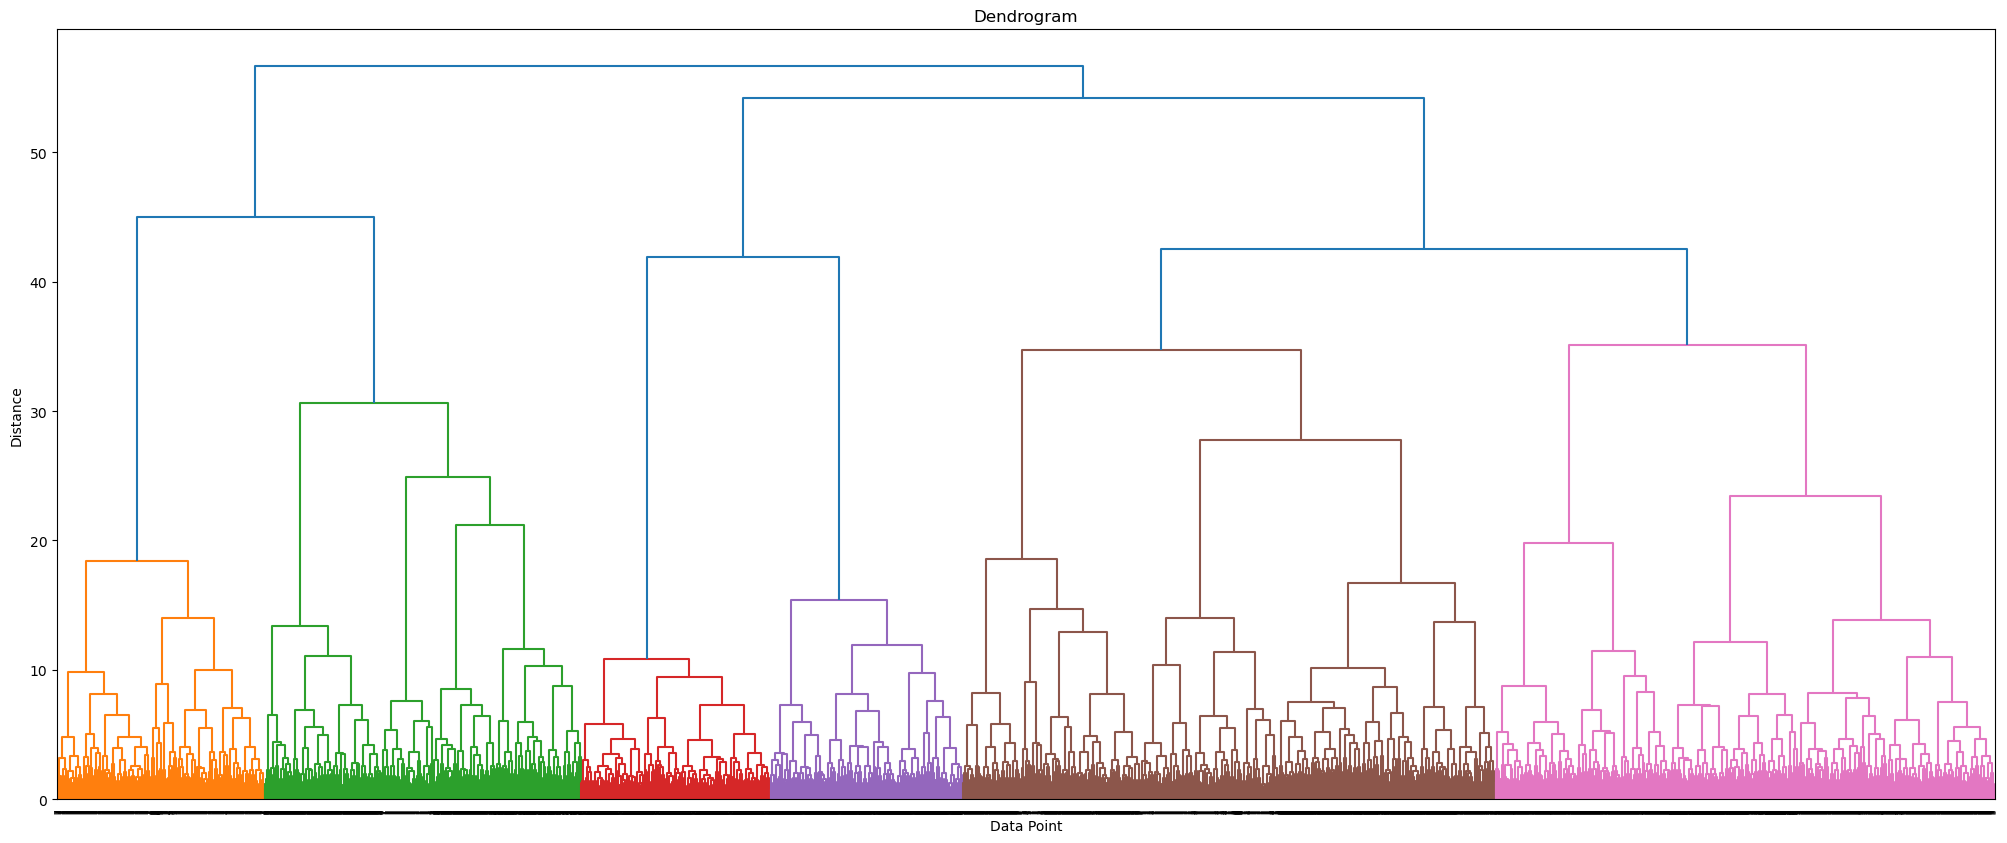

Training set cluster sizes: [392 638 346 352 428 373 380 409 233 271]
Testing set cluster sizes: [181 317 197 196 191 178 181 177  80  98]
Training set Calinski-Harabasz Index: 335.06848653227775
Training set Silhouette Index: 0.17449633801366315
Testing set Calinski-Harabasz Index: 161.00875227594696
Testing set Silhouette Index: 0.17831679069960052


In [6]:
#Hierarchical Agglomerative method

import pandas as pd
import numpy as np
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import calinski_harabasz_score, silhouette_score
import matplotlib.pyplot as plt

# Preprocess data
# Normalization
# Clustering


train_data = pd.read_csv("digitDset_train.csv")
test_data = pd.read_csv("digitDset_test.csv")

X_train = train_data.iloc[:, :-1].values
y_train = train_data.iloc[:, -1]

X_test = test_data.iloc[:, :-1].values
y_test = test_data.iloc[:, -1]

n_clusters = 10

X_train = (X_train - X_train.min()) / (X_train.max() - X_train.min())
X_test = (X_test - X_test.min()) / (X_test.max() - X_test.min())

Z = linkage(X_train, method='ward')
fig = plt.figure(figsize=(25, 10))
dn = dendrogram(Z, labels=y_train.to_numpy())
plt.xlabel('Data Point')
plt.ylabel('Distance')
plt.title('Dendrogram')
plt.show()

model = AgglomerativeClustering(n_clusters=n_clusters)
y_train = model.fit_predict(X_train)
y_test = model.fit_predict(X_test)

ch_train = calinski_harabasz_score(X_train, y_train)
si_train = silhouette_score(X_train, y_train)

ch_test = calinski_harabasz_score(X_test, y_test)
si_test = silhouette_score(X_test, y_test)

print("Training set cluster sizes:", np.unique(y_train, return_counts=True)[1])
print("Testing set cluster sizes:", np.unique(y_test, return_counts=True)[1])
print("Training set Calinski-Harabasz Index:", ch_train)
print("Training set Silhouette Index:", si_train)
print("Testing set Calinski-Harabasz Index:", ch_test)
print("Testing set Silhouette Index:", si_test)


#The dendrogram plot shows the hierarchical relationships between
#the clusters formed by the agglomerative clustering algorithm. The vertical axis of the dendrogram 
#represents the distance between the clusters, and the horizontal axis represents the data points.
#The dendrogram helps us visualize the merging process of the algorithm and the hierarchy of the resulting clusters.
